# Population Growth Analysis & Simple Forecasts (1952–2019)
Data cleaning, EDA, and simple forecasts: naive, linear trend, and moving-average.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

sns.set_style("whitegrid")
print("Libraries loaded")


Libraries loaded


In [4]:
from google.colab import files
uploaded = files.upload()
fn = list(uploaded.keys())[0]
print("Uploaded file:", fn)


Saving POP.csv to POP.csv
Uploaded file: POP.csv


In [5]:
#preview of the dataset
df = pd.read_csv(fn, parse_dates=['date'], infer_datetime_format=True)
df.columns = [c.strip().lower() for c in df.columns]
if 'value' in df.columns and 'population' not in df.columns:
    df = df.rename(columns={'value':'population'})
print(df.head())


  realtime_start  population       date realtime_end
0     2019-12-06    156309.0 1952-01-01   2019-12-06
1     2019-12-06    156527.0 1952-02-01   2019-12-06
2     2019-12-06    156731.0 1952-03-01   2019-12-06
3     2019-12-06    156943.0 1952-04-01   2019-12-06
4     2019-12-06    157140.0 1952-05-01   2019-12-06


/tmp/ipython-input-166650678.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(fn, parse_dates=['date'], infer_datetime_format=True)


In [11]:
#cleaning the dataset and analyzing
df['population'] = pd.to_numeric(df['population'], errors='coerce')
df = df.dropna(subset=['population','date']).copy()
df['year'] = df['date'].dt.year

annual = df.groupby('year', as_index=False)['population'].mean().sort_values('year')
print("Years:", annual['year'].min(), "to", annual['year'].max())
annual.head()


Years: 1952 to 2019


,year,population
0,1952,157492.583333
1,1953,160146.166667
2,1954,162968.250000
3,1955,165872.333333
4,1956,168857.666667


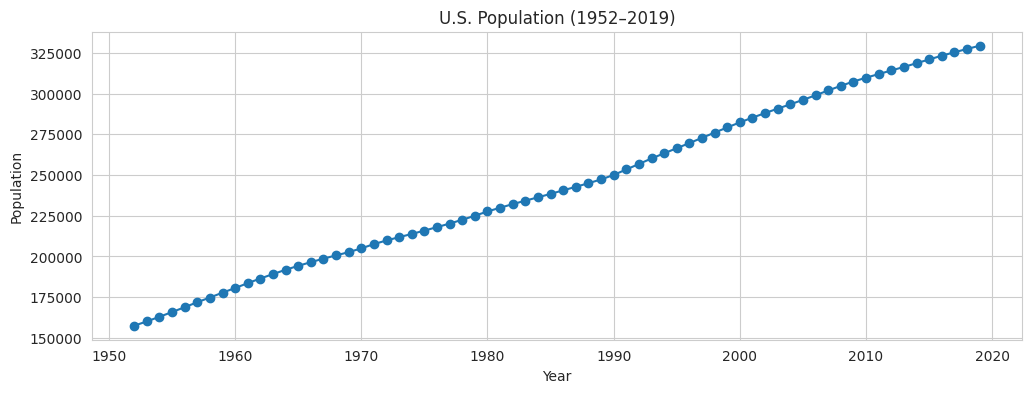

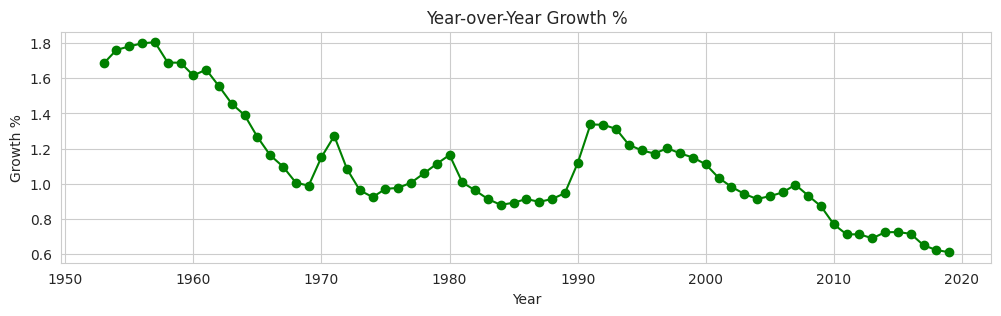

In [12]:
#exploration of trends
annual['pop_lag1'] = annual['population'].shift(1)
annual['growth_pct'] = (annual['population']/annual['pop_lag1'] - 1) * 100

plt.figure(figsize=(12,4))
plt.plot(annual['year'], annual['population'], marker='o')
plt.title('U.S. Population (1952–2019)')
plt.xlabel('Year'); plt.ylabel('Population'); plt.show()

plt.figure(figsize=(12,3))
plt.plot(annual['year'], annual['growth_pct'], marker='o', color='green')
plt.title('Year-over-Year Growth %'); plt.xlabel('Year'); plt.ylabel('Growth %'); plt.show()


In [13]:
#Train test split
horizon = 5
train = annual.iloc[:-horizon].reset_index(drop=True)
test  = annual.iloc[-horizon:].reset_index(drop=True)

print("Train:", train['year'].min(), "-", train['year'].max())
print("Test :", test['year'].min(), "-", test['year'].max())


Train: 1952 - 2014
Test : 2015 - 2019


In [15]:
#Naives
last_pop = train['population'].iloc[-1]
test['pred_naive'] = last_pop

mape_naive = mean_absolute_percentage_error(test['population'], test['pred_naive'])
rmse_naive = np.sqrt(mean_squared_error(test['population'], test['pred_naive']))
print(f"Naive → MAPE: {mape_naive*100:.2f}% | RMSE: {rmse_naive:.2f}")


Naive → MAPE: 2.03% | RMSE: 7251.26


In [16]:
#linear trends
lr = LinearRegression()
X_train = train[['year']]
y_train = train['population']
lr.fit(X_train, y_train)

test['pred_linear'] = lr.predict(test[['year']])

mape_lr = mean_absolute_percentage_error(test['population'], test['pred_linear'])
rmse_lr = np.sqrt(mean_squared_error(test['population'], test['pred_linear']))
print(f"Linear Trend → MAPE: {mape_lr*100:.2f}% | RMSE: {rmse_lr:.2f}")


Linear Trend → MAPE: 0.24% | RMSE: 918.36


In [17]:
# moving averages
ma_value = train['population'].rolling(3).mean().iloc[-1]
test['pred_ma'] = ma_value

mape_ma = mean_absolute_percentage_error(test['population'], test['pred_ma'])
rmse_ma = np.sqrt(mean_squared_error(test['population'], test['pred_ma']))
print(f"Moving Average (3 yr) → MAPE: {mape_ma*100:.2f}% | RMSE: {rmse_ma:.2f}")


Moving Average (3 yr) → MAPE: 2.72% | RMSE: 9348.70


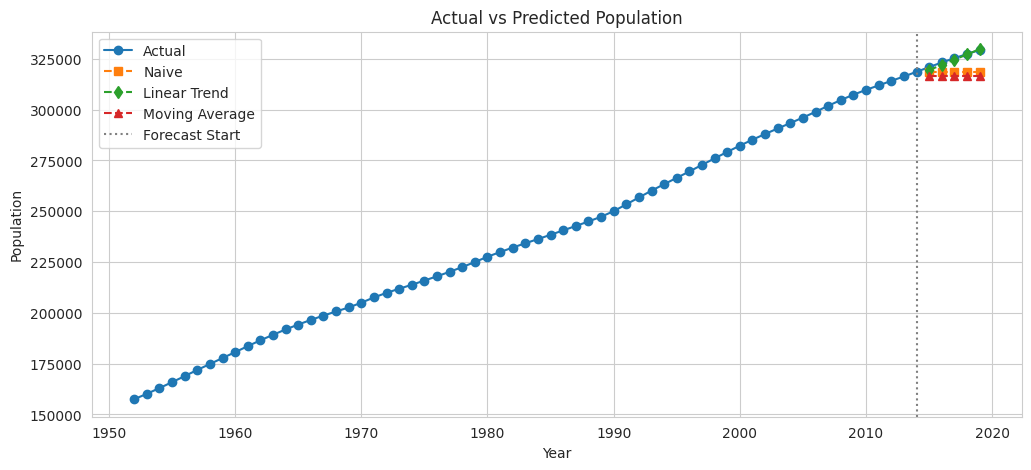

   year     population     pred_naive    pred_linear        pred_ma
0  2015  320929.533083  318619.452833  319475.471780  316370.618583
1  2016  323224.626667  318619.452833  322040.693848  316370.618583
2  2017  325326.015500  318619.452833  324605.915916  316370.618583
3  2018  327351.664000  318619.452833  327171.137985  316370.618583
4  2019  329349.340417  318619.452833  329736.360053  316370.618583


In [18]:
#comparing the results visually
plt.figure(figsize=(12,5))
plt.plot(annual['year'], annual['population'], label='Actual', marker='o')
plt.plot(test['year'], test['pred_naive'], '--s', label='Naive')
plt.plot(test['year'], test['pred_linear'], '--d', label='Linear Trend')
plt.plot(test['year'], test['pred_ma'], '--^', label='Moving Average')
plt.axvline(x=train['year'].iloc[-1], color='gray', linestyle=':', label='Forecast Start')
plt.legend(); plt.xlabel('Year'); plt.ylabel('Population')
plt.title('Actual vs Predicted Population'); plt.show()

print(test[['year','population','pred_naive','pred_linear','pred_ma']])


In [19]:
#prediction of next 5 years
future_years = np.arange(annual['year'].max()+1, annual['year'].max()+6)
future_df = pd.DataFrame({'year': future_years})
future_df['pred_linear'] = lr.predict(future_df[['year']])
future_df['pred_naive']  = annual['population'].iloc[-1]
future_df['pred_ma']     = ma_value

print("Future forecasts:")
print(future_df.round(2))



Future forecasts:
   year  pred_linear  pred_naive    pred_ma
0  2020    332301.58   329349.34  316370.62
1  2021    334866.80   329349.34  316370.62
2  2022    337432.03   329349.34  316370.62
3  2023    339997.25   329349.34  316370.62
4  2024    342562.47   329349.34  316370.62


# Population Growth Analysis & Simple Predictions

**Goal:** Explore U.S. population data (1952–2019) and make simple forecasts (naive, linear trend, moving average).

**Results (example):**
- Naive MAPE = …
- Linear Trend MAPE = …
- Moving Average MAPE = …

**Tools:** Python, Pandas, Matplotlib, Seaborn, Colab  
**Data Source:** U.S. Census / FRED (POP.csv)


In [20]:
# 🌸 FINAL EXPORT & DOWNLOAD CELL
import matplotlib.pyplot as plt
from google.colab import files

# 1️ Save main forecast plot as PNG
plt.figure(figsize=(12,5))
plt.plot(annual['year'], annual['population'], label='Actual', marker='o')
plt.plot(test['year'], test['pred_naive'], '--s', label='Naive')
plt.plot(test['year'], test['pred_linear'], '--d', label='Linear Trend')
plt.plot(test['year'], test['pred_ma'], '--^', label='Moving Average')
plt.axvline(x=train['year'].iloc[-1], color='gray', linestyle=':', label='Forecast Start')
plt.legend(); plt.xlabel('Year'); plt.ylabel('Population')
plt.title('Population Forecast Comparison (1952–2019)')
plt.savefig('population_forecast.png', dpi=150)
plt.close()

# 2️ Save CSV outputs
test.to_csv('predictions_test.csv', index=False)
future_df.to_csv('future_forecasts.csv', index=False)

# 3️ Create a short README text file
readme_text = """Population Growth Analysis & Simple Predictions (1952–2019)
---------------------------------------------------------
Files included:
1. Population_Growth_Analysis.ipynb — Colab notebook
2. population_forecast.png — visualization chart
3. predictions_test.csv — test-year predictions
4. future_forecasts.csv — 5-year simple forecasts

Tools: Python | Pandas | Matplotlib | Google Colab
Data Source: U.S. Census / FRED (POP.csv)
"""
with open("README.txt", "w") as f:
    f.write(readme_text)

# 4️ Download all generated files automatically
files.download('population_forecast.png')
files.download('predictions_test.csv')
files.download('future_forecasts.csv')
files.download('README.txt')

print(" All files saved and ready for upload to LinkedIn / GitHub!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ All files saved and ready for upload to LinkedIn / GitHub!
